In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import keras
from keras.models import *
from keras.layers import *
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras import backend as K
K.set_session(session)

C:\Users\peter\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATASET_ROOT = './0518'
TRAIN_PATH = os.path.join(DATASET_ROOT, 'taetfp.csv')
TS_IN=8
TS_OUT=5
fields = ['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)', '成交張數(張)']
fields_dict = dict()
for n, f in enumerate(fields):
    fields_dict[f] = n

,代碼,日期,中文簡稱,開盤價(元),最高價(元),最低價(元),收盤價(元),成交張數(張)
0,50,20130102,元大台灣50,46.57,47.13,46.49,46.92,16487.0
5268,54,20130102,元大台商50,16.84,16.84,16.54,16.75,20.0
7902,56,20130102,元大高股息,18.45,18.63,18.45,18.55,1623.0
9219,57,20130102,富邦摩台,30.35,30.69,30.35,30.69,69.0
3951,53,20130102,元大電子,19.84,19.84,19.52,19.81,42.0
10536,58,20130102,富邦發達,32.45,32.45,32.12,32.12,2.0
11853,59,20130102,富邦金融,24.65,24.65,24.65,24.65,2.0
2634,52,20130102,富邦科技,26.57,26.95,26.57,26.92,26.0
13170,6201,20130102,元大富櫃50,9.08,9.18,9.01,9.13,254.0
14487,6203,20130102,元大MSCI台灣,22.61,22.61,22.56,22.56,28.0


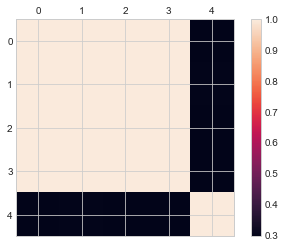

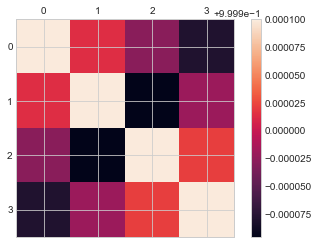

In [3]:
train_csv = pd.read_csv(TRAIN_PATH)
train_csv.sort_values(by=['日期'], ascending=True, inplace=True)
train_csv[fields] = train_csv[fields].applymap(lambda x: float(x.replace(',','')) if type(x)==str else x)
display(train_csv.head(n=10))
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[fields].corr())
fig.colorbar(cax)
plt.show()
fig, ax = plt.subplots()
cax = ax.matshow(train_csv[['開盤價(元)', '最高價(元)', '最低價(元)', '收盤價(元)']].corr())
fig.colorbar(cax)
plt.show()

In [4]:
codes = list(sorted(set(train_csv['代碼'])))

code 50


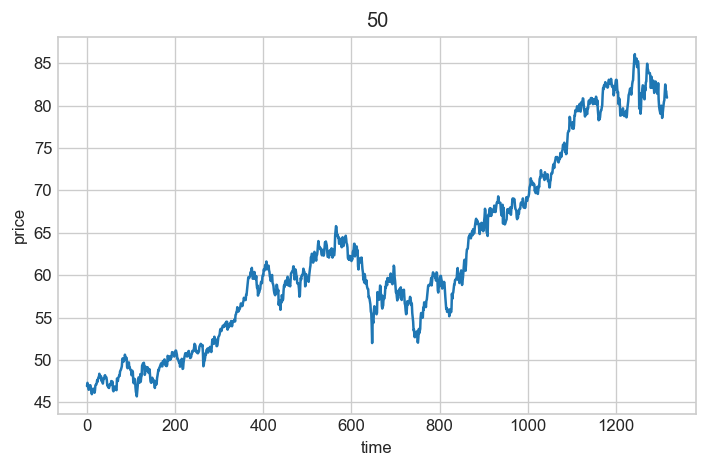

code 51


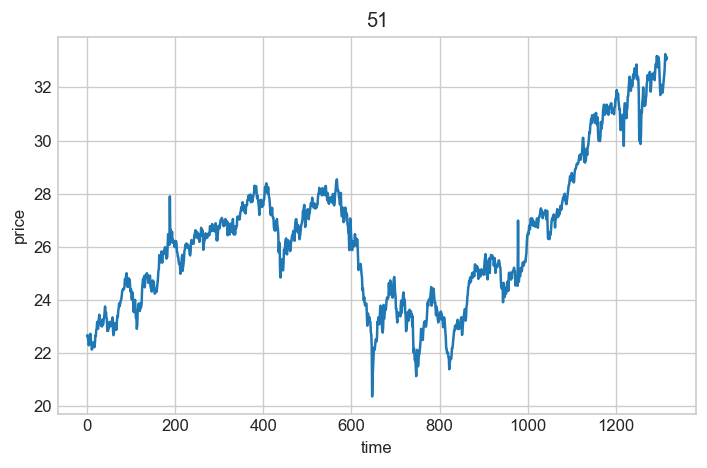

code 52


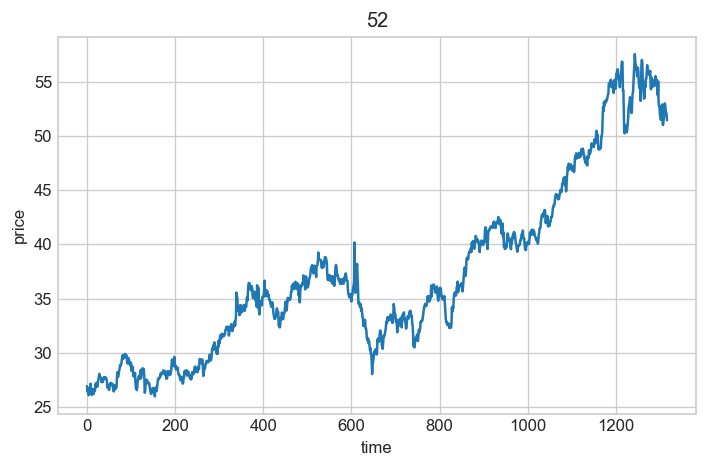

code 53


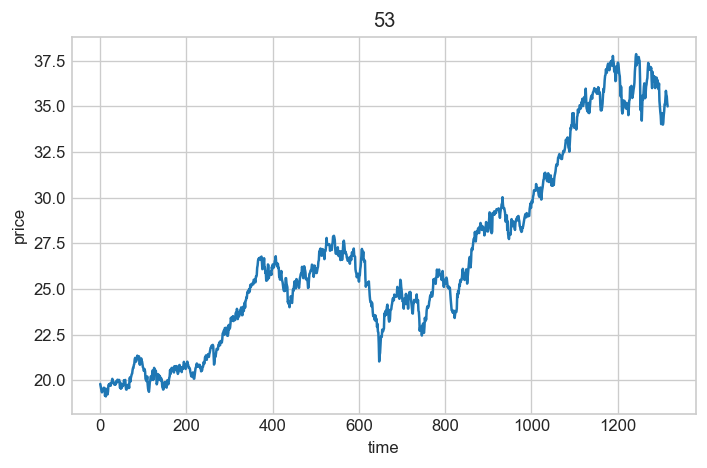

code 54


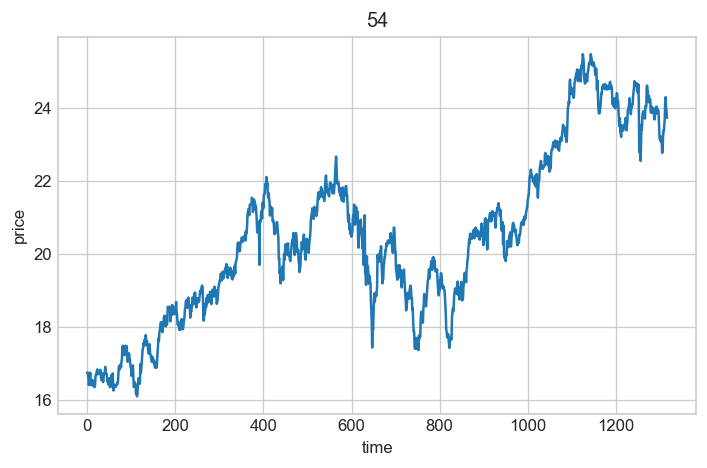

code 55


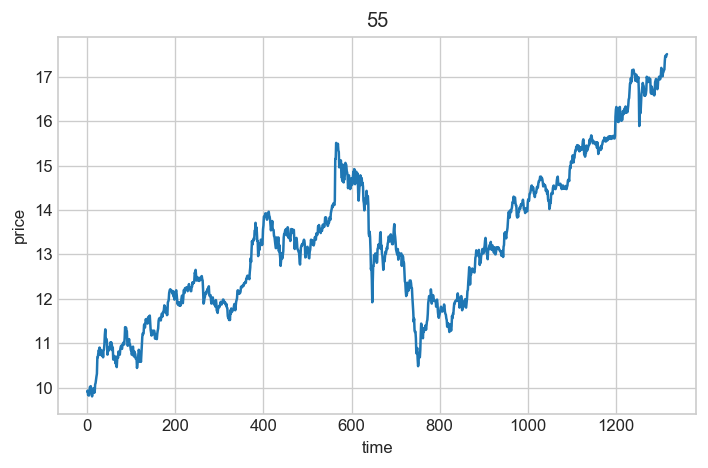

code 56


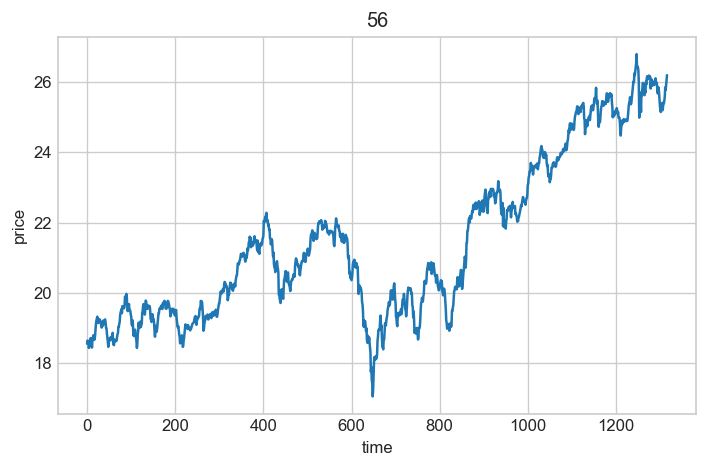

code 57


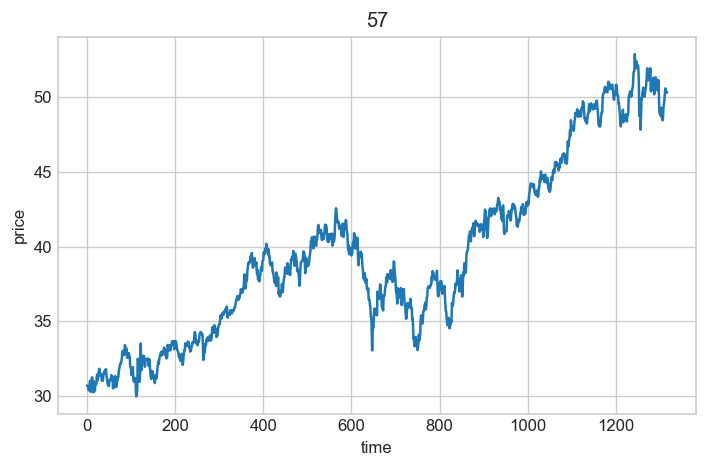

code 58


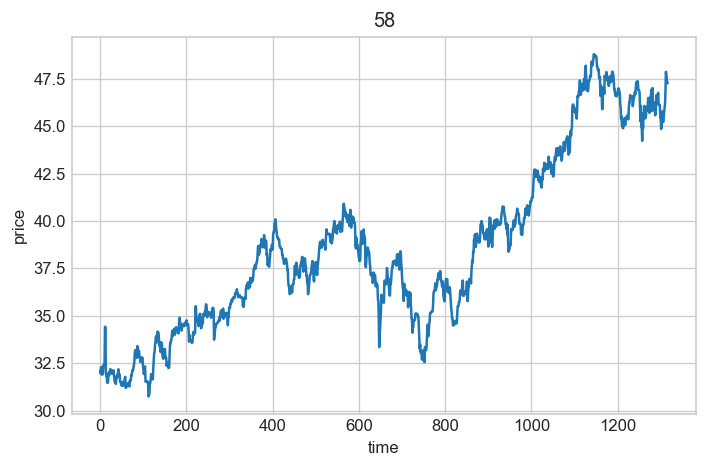

code 59


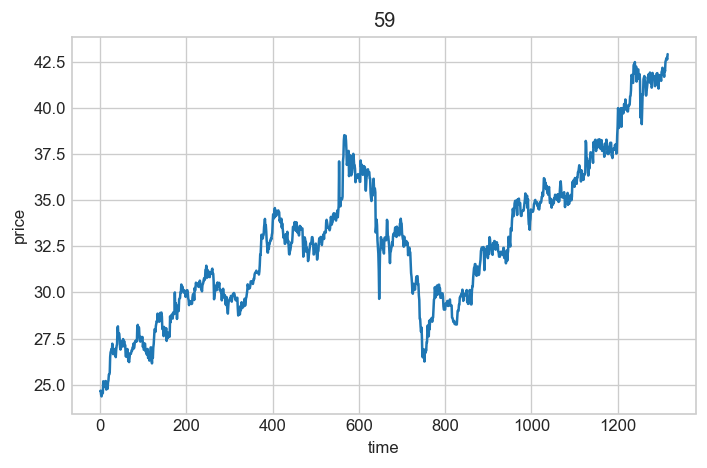

code 690


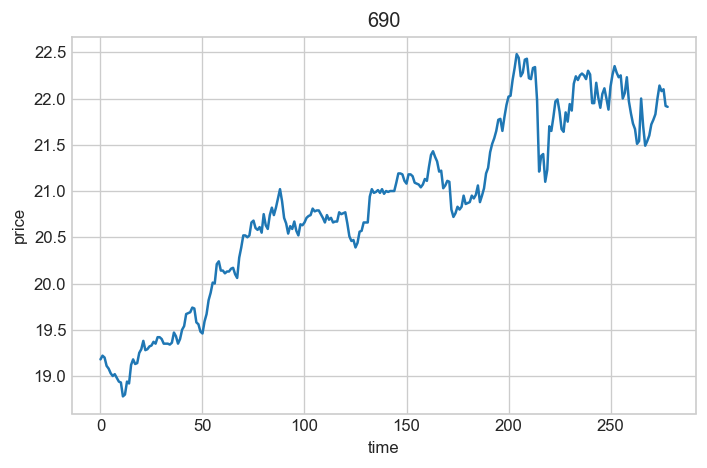

code 692


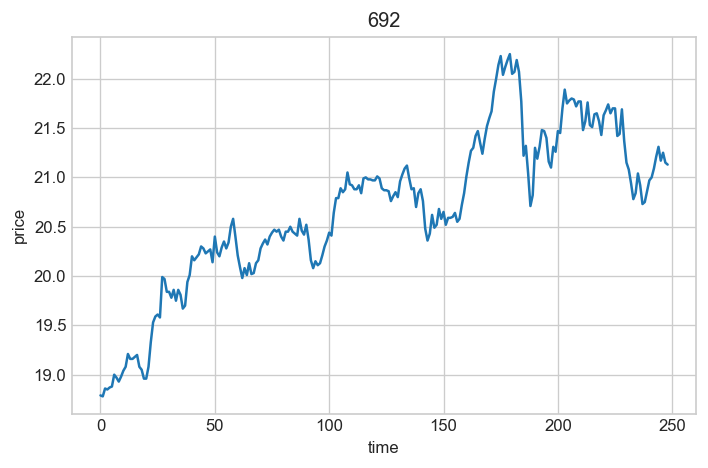

code 701


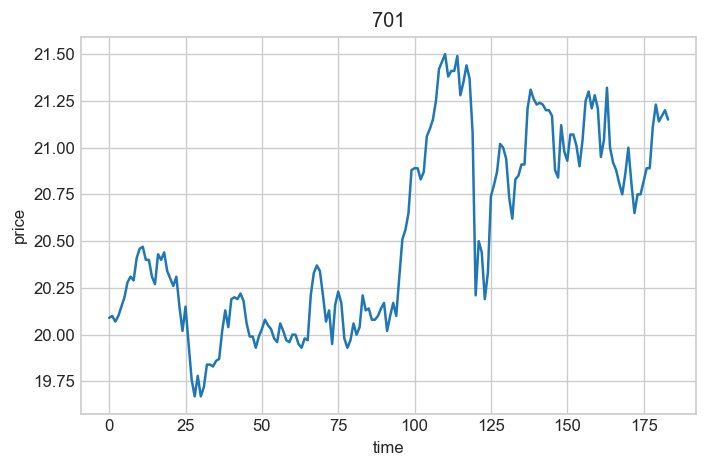

code 713


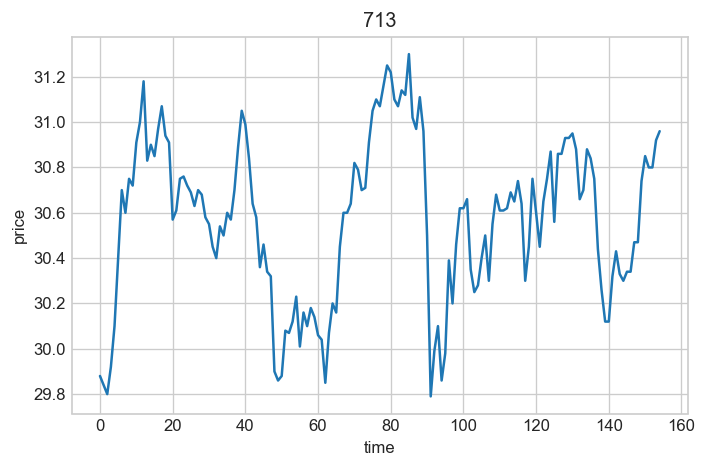

code 6201


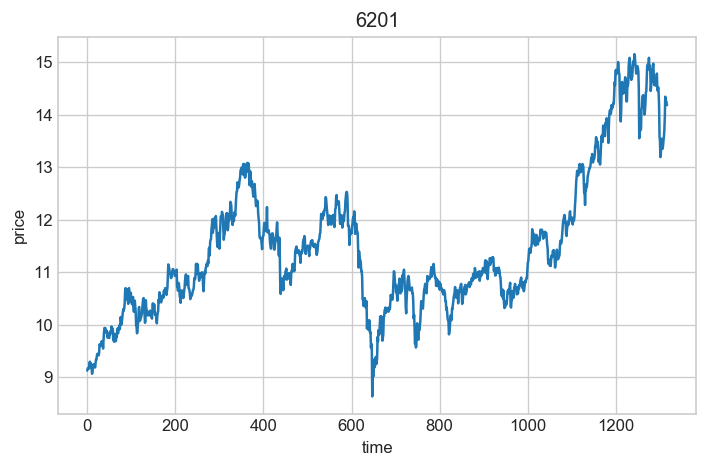

code 6203


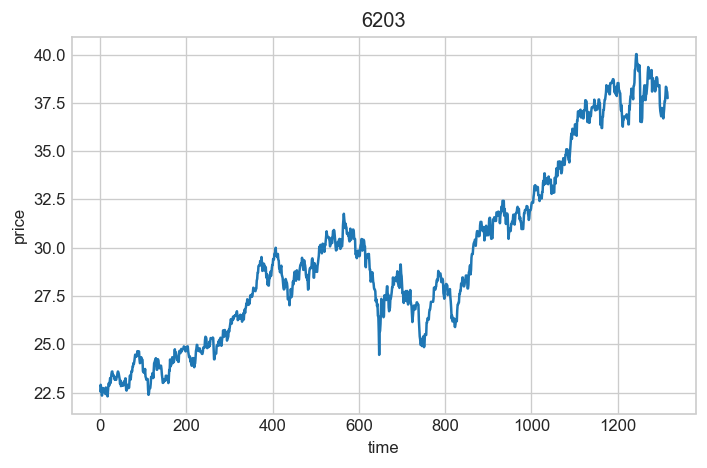

code 6204


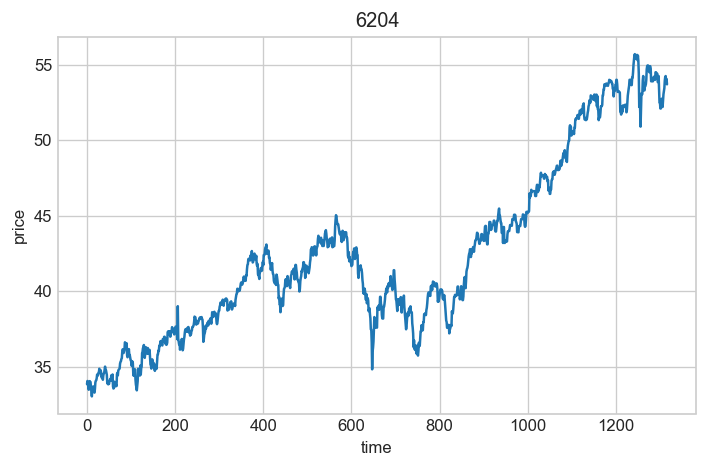

code 6208


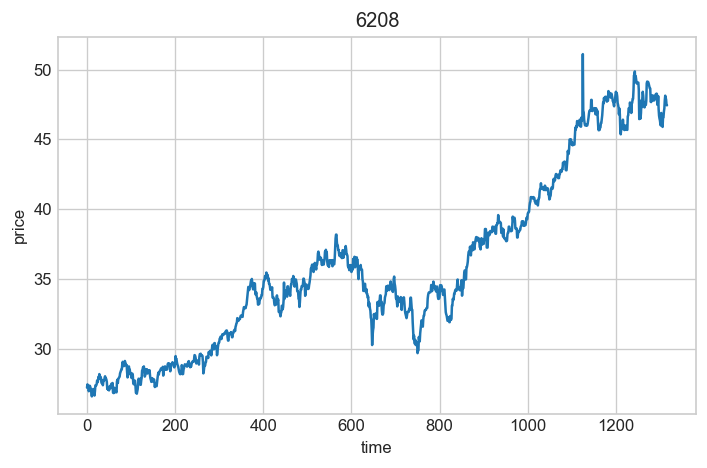

In [5]:
split_train = []
for code in codes:
    row   = np.asarray(train_csv.loc[train_csv['代碼']==code][fields], dtype=np.float32)
    label = np.append(np.array([0], dtype=np.float32), (row[1:,-2] > row[:-1,-2]).astype(np.float32)).astype(np.float32)[...,np.newaxis]
    #row[day-0:, 收盤價] > row[:day-n, 收盤價]
    row = np.append(row, label, axis=-1)
    print('code {:d}'.format(code))
    fit, ax = plt.subplots(dpi=120)
    ax.set_title(str(code))
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    ax.plot(range(row.shape[0]), row[...,fields_dict['收盤價(元)']])
    plt.tight_layout()
    plt.show()
    split_train.append(row)

In [6]:
for n, s in enumerate(split_train):
    print(codes[n], len(s))

50 1317
51 1317
52 1317
53 1317
54 1317
55 1317
56 1317
57 1317
58 1317
59 1317
690 279
692 249
701 184
713 155
6201 1317
6203 1317
6204 1317
6208 1317


In [7]:
from keras.regularizers import *

# custom R2-score metrics for keras backend
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) # mse, model interpretable error
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) # y_true likelyhood variance, not interpretable error
    return (1 - SS_res/(SS_tot + K.epsilon()))
    # if SS_res == SS_tot: at least the model can fit to some extent
    # if SS_res >> SS_tot: the model is lame

def classification_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    eq = K.cast(K.equal(K.round(y_true), K.round(y_pred)), 'float32') # shape: batch size, 5, 1 
    return K.mean(K.sum(eq * weights, axis=-2)) # dot_product(eq(batch size, 5, 1), weights(1,5,1)) -> K.mean((batch size, 1)) -> score

def regress_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wmse = K.mean(K.sum(K.square(y_true-y_pred) * weights, axis=-2)) # mean squared error with weights
    return wmse

def classification_loss(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    wbce = K.mean(K.sum(K.binary_crossentropy(y_true, y_pred) * weights, axis=-2))
    return wbce

def regression_score(y_true, y_pred):
    weights = K.constant([0.1, 0.15, 0.2, 0.25, 0.3], dtype='float32', shape=(1,5,1))
    return K.mean(K.sum((y_true - K.abs(y_pred-y_true)) / (y_true+K.epsilon()) * weights, axis=-2))

def make_model(ts_in=60, ts_out=5, n_field=6, n_encode=128, n_decode=128, reg_a=0.1):
    def l_(inputs):
        inputs_layer, regression = inputs
        c = K.concatenate([inputs_layer[...,3:4], regression], axis=-2) # shape: (batch_size, ts_in+ts_out, 1)
        ud = K.cast(K.greater(c[...,-ts_out:,:] - c[...,-ts_out-1:-1,:], 0), 'float32') # shape: (batch_size, ts_out, 1)
        return ud
    input_ = Input(shape=(ts_in, n_field))
    lstm_1 = CuDNNLSTM(n_encode, return_sequences=False, recurrent_regularizer=l2(reg_a)) (input_)
    rep_vec_2 = RepeatVector(ts_out) (lstm_1)
    lstm_3 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (rep_vec_2)
    lstm_4 = CuDNNLSTM(n_decode, return_sequences=True, recurrent_regularizer=l2(reg_a)) (lstm_3)
    fc_4_regression     = TimeDistributed(Dense(1, kernel_regularizer=l2(reg_a)), name='regression') (lstm_4)
    fc_4_classification = Lambda(l_, name='class') ([input_, fc_4_regression])
    return Model([input_], [fc_4_regression, fc_4_classification])
make_model(ts_in=TS_IN, ts_out=TS_OUT).summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 6)         0                                            
__________________________________________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)        (None, 128)          69632       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 128)       0           cu_dnnlstm_1[0][0]               
__________________________________________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)        (None, 5, 128)       132096      repeat_vector_1[0][0]            
__________________________________________________________________________________________________
cu_dnnlstm

In [8]:
def make_seq(seq, ts_in=60, ts_out=5):
    Xs = []
    Ys = []
    Ys_label = []
    total_l = ts_in + ts_out
    for i in range(0, len(seq)-total_l+1):
        Xs.append(seq[i:i+ts_in])
        Ys.append(seq[i+ts_in:i+total_l, 3:4])
        Ys_label.append(seq[i+ts_in:i+total_l, -1:]) # 漲跌
    return np.asarray(Xs), np.asarray(Ys), np.asarray(Ys_label)

In [9]:
train_18 = []
for seq in split_train:
    Xs, Ys, Ys_label = make_seq(seq, ts_in=TS_IN, ts_out=TS_OUT)
    train_18.append([Xs, Ys, Ys_label])

In [10]:
from matplotlib.figure import figaspect
def vis(history, title='no title', dpi=80):
    # r2, classification_score, regression_score, lb
    fig_, ax_ = plt.subplots(2, 3, dpi=80, figsize=(20, 5))
    ax = ax_.ravel()
    titles = ['wmse', 'wmse', 'r2', 'classification_score', 'regression_score', 'lb']
    for i, p in enumerate(titles):
        ax[i].set_title(title + ' ' + p + ' plot')
    for i in range(6):
        ax[i].set_xlabel('epoch')
    scores = ['wmse', 'wmse', 'r2', 'acc', 't_brain_regression', 'lb']
    for i, s in enumerate(scores):
        ax[i].set_ylabel(s)
    metric_names = ['regression_loss', 'regression_loss', 'regression_r2_keras', 'class_classification_score', 'regression_regression_score']
    locs = [0, 0, 1, 1, 1]
    for i, (name, loc) in enumerate(zip(metric_names, locs)):
        ax[i].plot(history.history[name])
        ax[i].plot(history.history['val_'+name])
        ax[i].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    ax[-1].plot(0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score']))
    ax[-1].plot(0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score']))
    ax[-1].legend(['train','valid'], loc='upper right' if loc==0 else 'lower right')
    plt.tight_layout()
    plt.show()

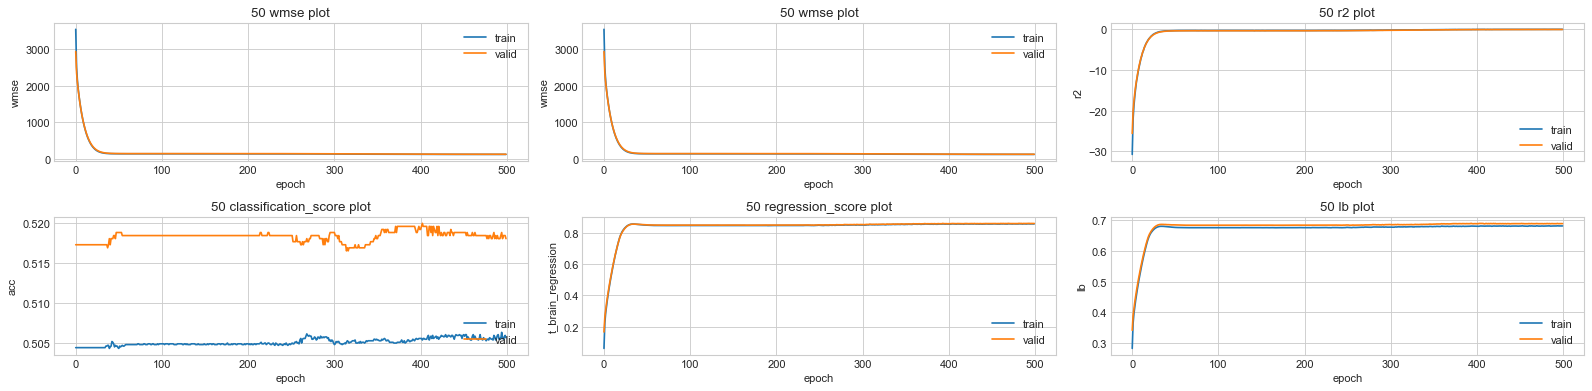

validation wmse: 123.272190
validation r2 : -0.091811
validation acc: 0.518008
validation regression: 0.858488
validation lb: 0.688248


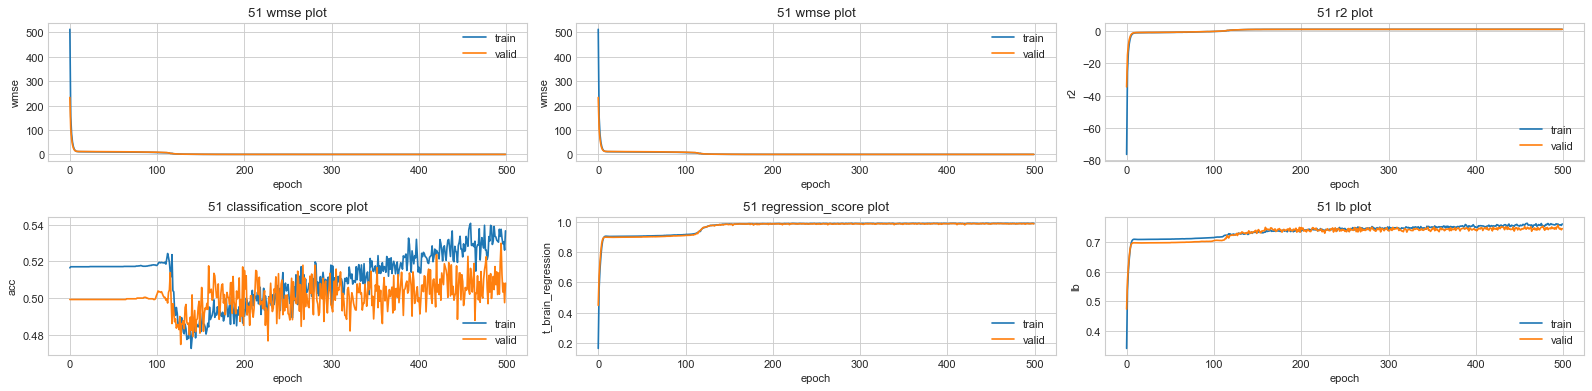

validation wmse: 0.342707
validation r2 : 0.943787
validation acc: 0.508238
validation regression: 0.984543
validation lb: 0.746390


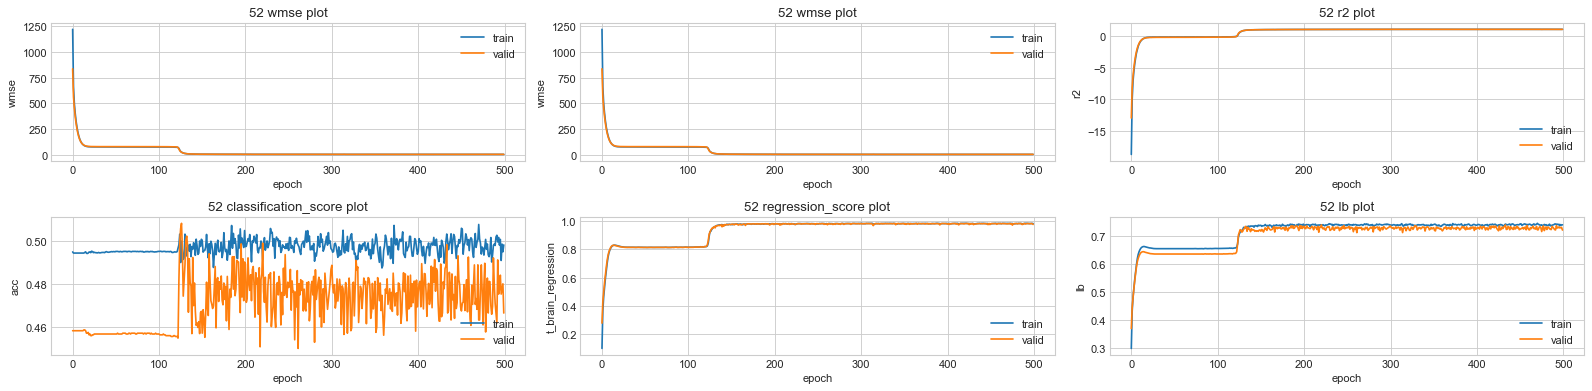

validation wmse: 1.551919
validation r2 : 0.971804
validation acc: 0.466667
validation regression: 0.975647
validation lb: 0.721157


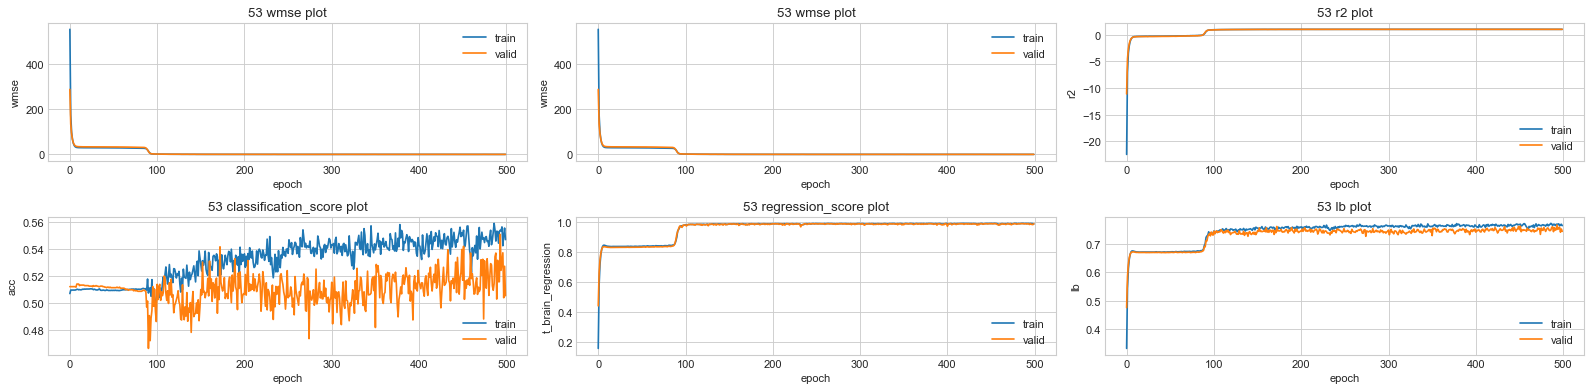

validation wmse: 0.416224
validation r2 : 0.980488
validation acc: 0.505556
validation regression: 0.984884
validation lb: 0.745220


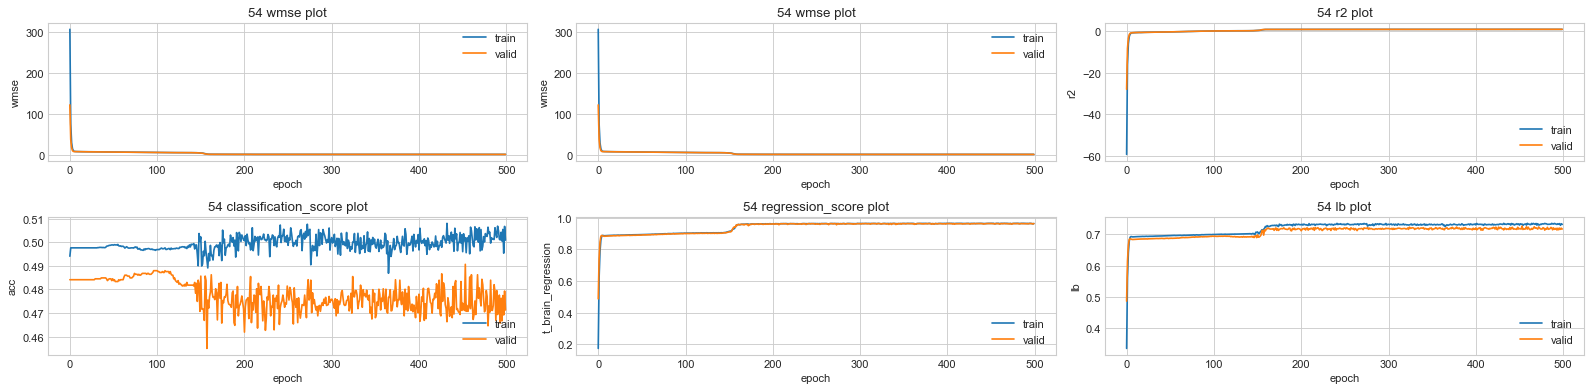

validation wmse: 1.341450
validation r2 : 0.603550
validation acc: 0.471264
validation regression: 0.964004
validation lb: 0.717634


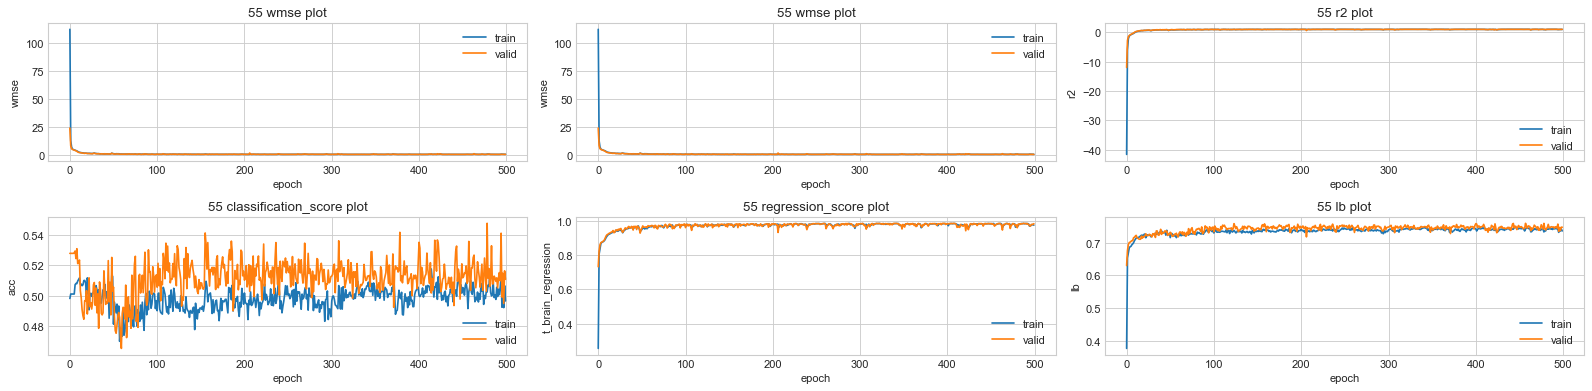

validation wmse: 0.101971
validation r2 : 0.953864
validation acc: 0.510728
validation regression: 0.983150
validation lb: 0.746939


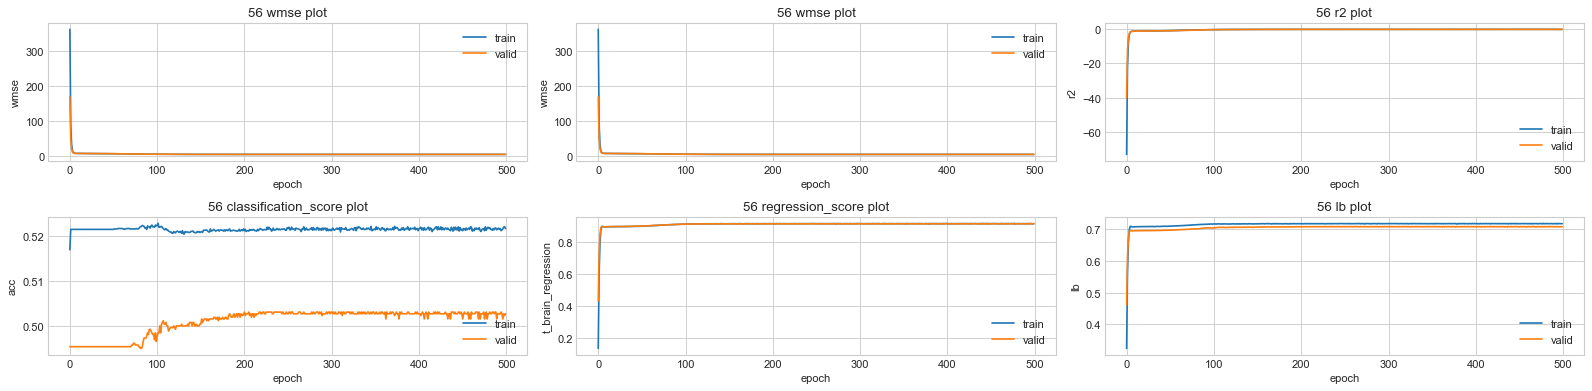

validation wmse: 5.282234
validation r2 : -0.054047
validation acc: 0.502682
validation regression: 0.911345
validation lb: 0.707013


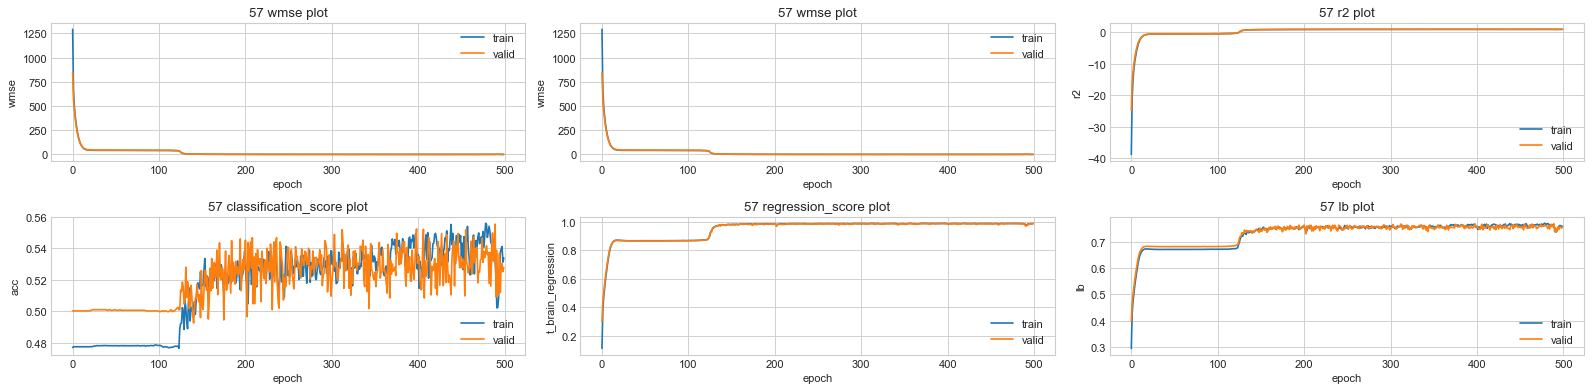

validation wmse: 0.816547
validation r2 : 0.970527
validation acc: 0.527778
validation regression: 0.984916
validation lb: 0.756347


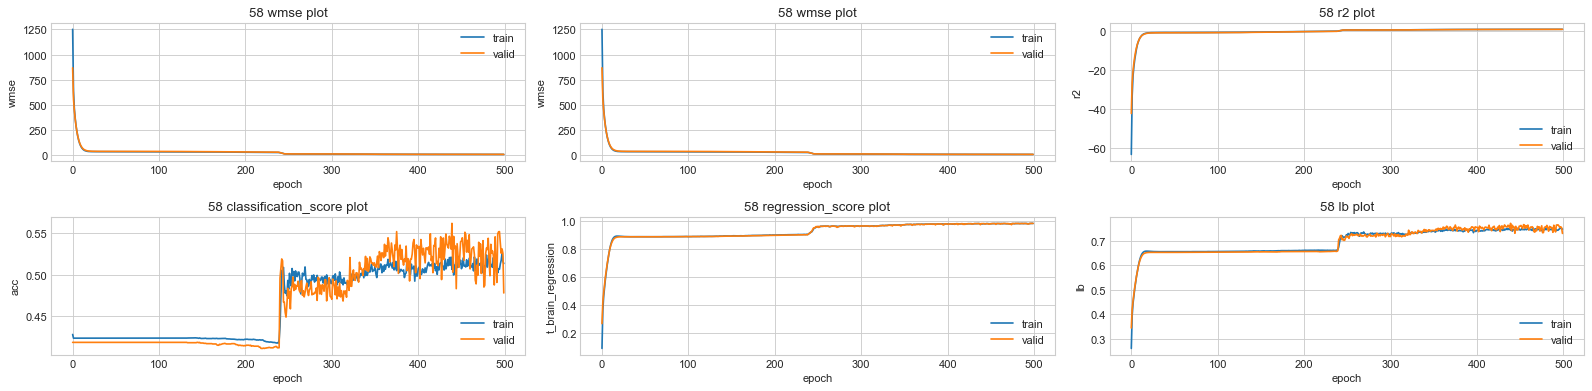

validation wmse: 1.452866
validation r2 : 0.889326
validation acc: 0.477778
validation regression: 0.983558
validation lb: 0.730668


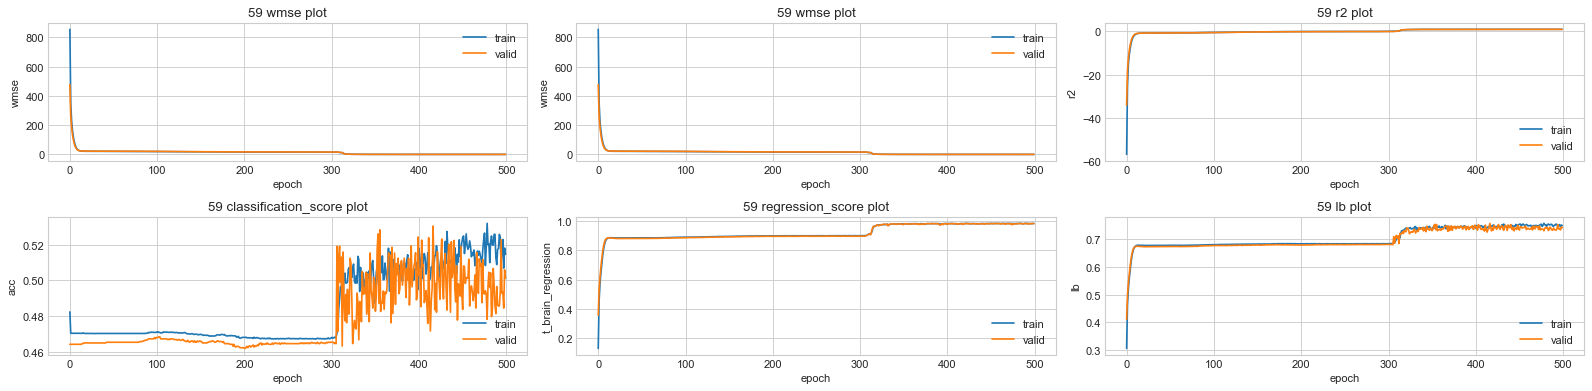

validation wmse: 0.720580
validation r2 : 0.946353
validation acc: 0.501341
validation regression: 0.982912
validation lb: 0.742127


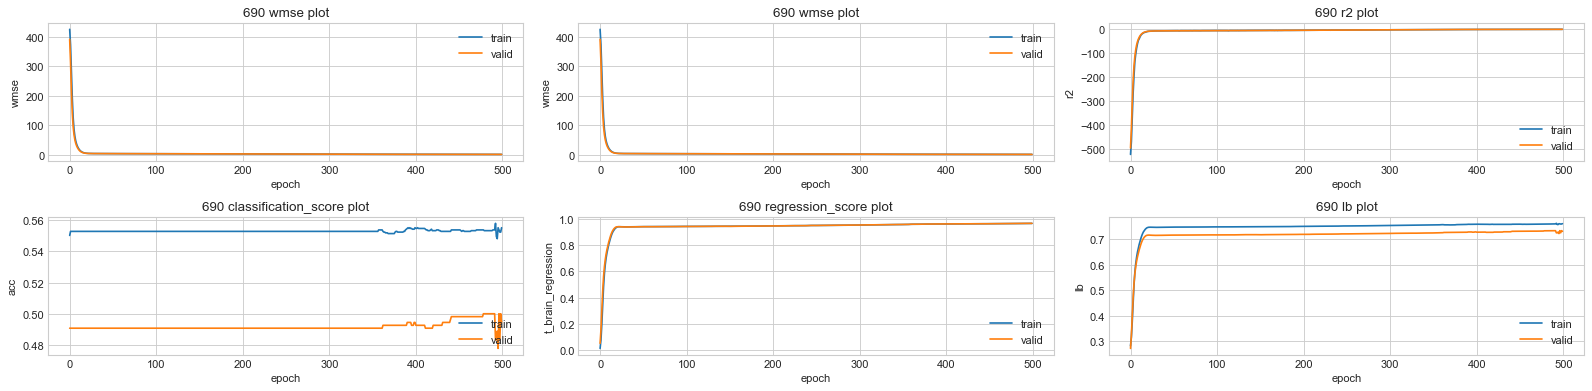

validation wmse: 0.780122
validation r2 : -0.088258
validation acc: 0.494444
validation regression: 0.965275
validation lb: 0.729860


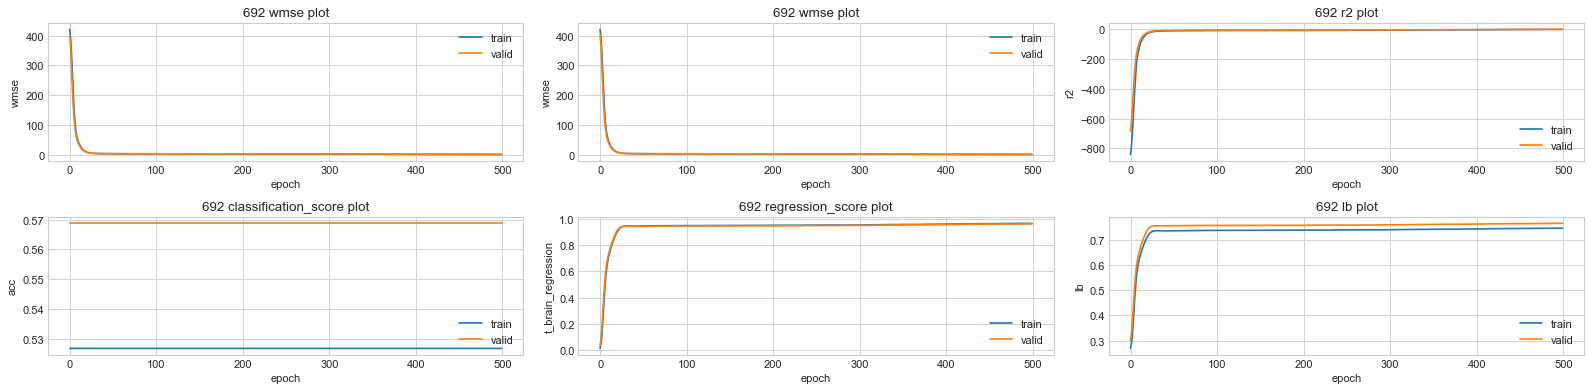

validation wmse: 1.059994
validation r2 : -1.506803
validation acc: 0.568750
validation regression: 0.960684
validation lb: 0.764717


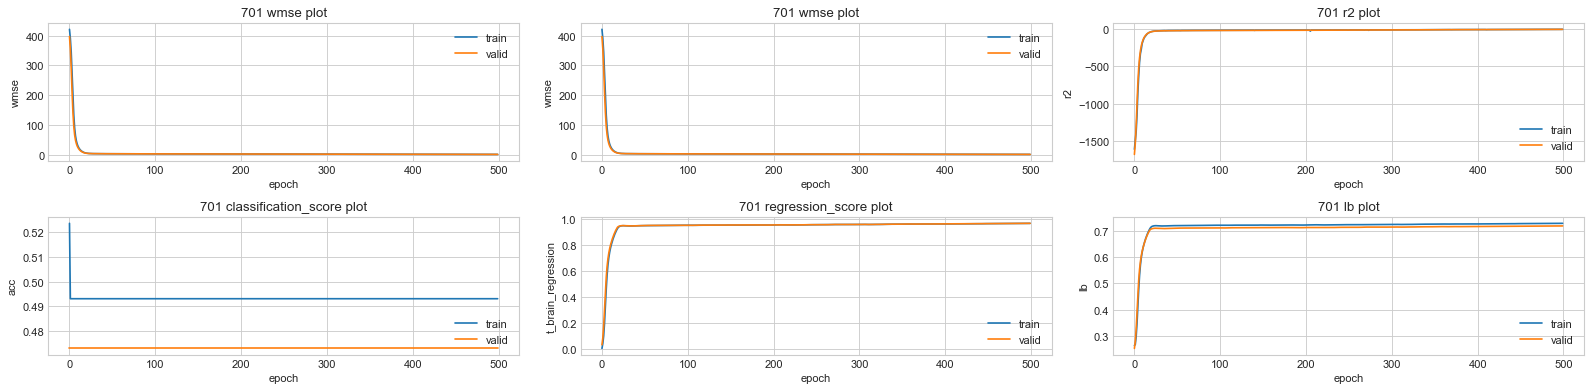

validation wmse: 0.851120
validation r2 : -4.700866
validation acc: 0.472857
validation regression: 0.966916
validation lb: 0.719887


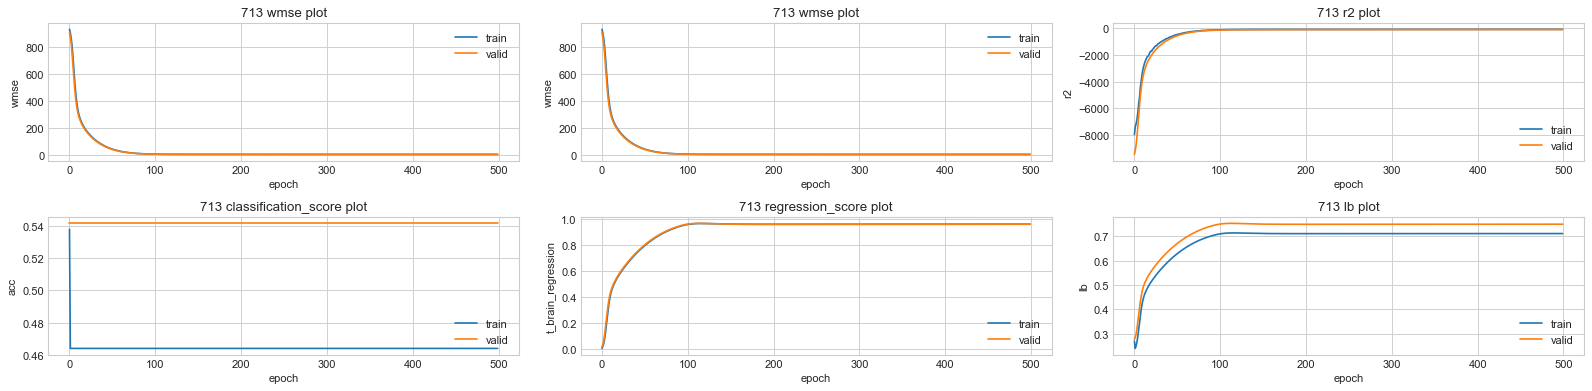

validation wmse: 4.976410
validation r2 : -95.147186
validation acc: 0.541379
validation regression: 0.957137
validation lb: 0.749258


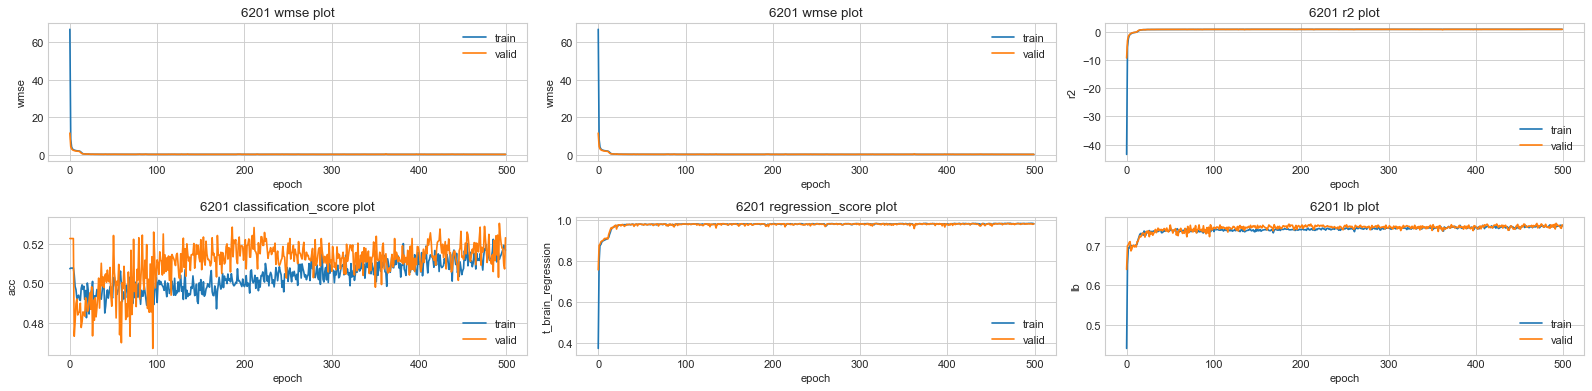

validation wmse: 0.084339
validation r2 : 0.939789
validation acc: 0.522989
validation regression: 0.982487
validation lb: 0.752738


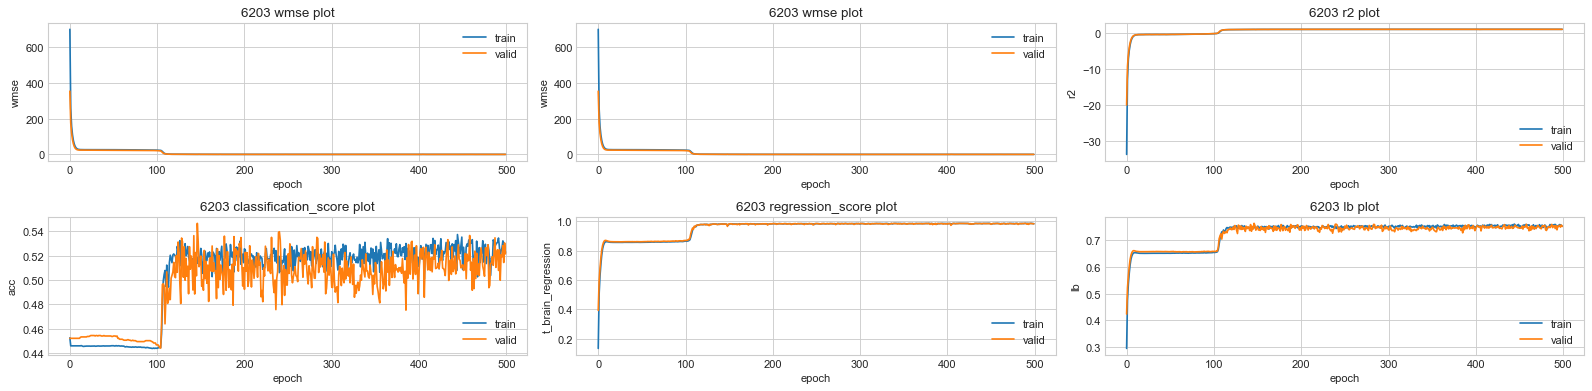

validation wmse: 0.395834
validation r2 : 0.975160
validation acc: 0.521456
validation regression: 0.984207
validation lb: 0.752831


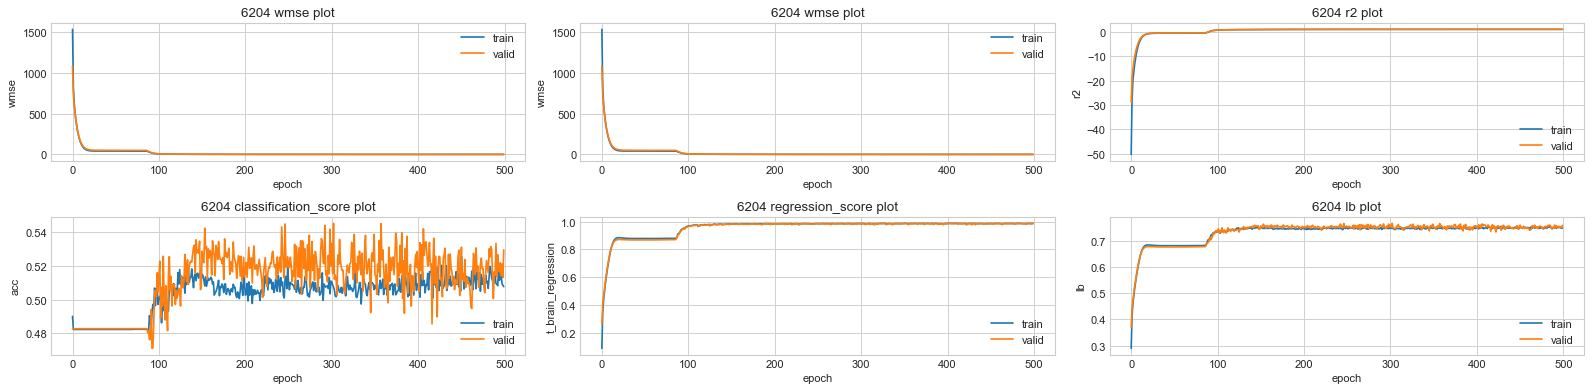

validation wmse: 0.906009
validation r2 : 0.967250
validation acc: 0.529502
validation regression: 0.985889
validation lb: 0.757696


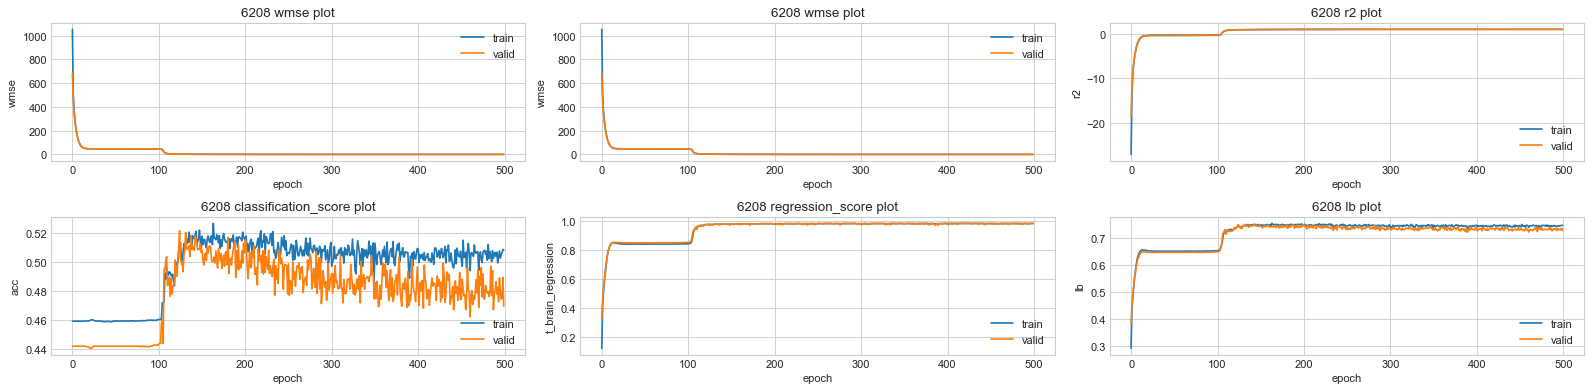

validation wmse: 0.593458
validation r2 : 0.978832
validation acc: 0.469349
validation regression: 0.986570
validation lb: 0.727959


In [11]:
from keras.callbacks import *
from sklearn.model_selection import train_test_split
BATCH_SIZE = 64
EPOCH = 500
total_lb = None
total_vlb = None
for model_n, (X, Y, label) in enumerate(train_18):
    X_train, X_test, Y_train, Y_test, label_train, label_test = train_test_split(X, Y, label, test_size=0.2)
    prefix = str(codes[model_n])
    model = make_model(ts_in=TS_IN, ts_out=TS_OUT)
    model.compile(loss={'regression':regress_loss, 'class':lambda x, y: K.constant(0)}, optimizer='adam', metrics = {'regression':[r2_keras, regression_score], 'class':[classification_score]}, loss_weights={'class':0, 'regression':1})
    history = model.fit(X_train, [Y_train, label_train], validation_data=(X_test, [Y_test, label_test]) , batch_size=BATCH_SIZE, epochs=EPOCH, callbacks=[TensorBoard(log_dir=prefix+'_logs')], shuffle=True, verbose=0)
    vis(history, title=prefix, dpi=180)
    # print('validation wbce: {:.6f}'.format(history.history['val_class_loss'][-1]))
    print('validation wmse: {:.6f}'.format(history.history['val_regression_loss'][-1]))
    print('validation r2 : {:.6f}'.format(history.history['val_regression_r2_keras'][-1]))
    print('validation acc: {:.6f}'.format(history.history['val_class_classification_score'][-1]))
    print('validation regression: {:.6f}'.format(history.history['val_regression_regression_score'][-1]))
    print('validation lb: {:.6f}'.format(0.5*history.history['val_regression_regression_score'][-1]+0.5*history.history['val_class_classification_score'][-1]))
    lb = 0.5 * np.asarray(history.history['class_classification_score']) + 0.5 * np.asarray(history.history['regression_regression_score'])
    val_lb = 0.5 * np.asarray(history.history['val_class_classification_score']) + 0.5 * np.asarray(history.history['val_regression_regression_score'])
    if total_lb is None: # compute total lb and plot lb plot
        total_lb = lb
        total_vlb = val_lb
    else:
        total_lb = total_lb + lb
        total_vlb = total_vlb + val_lb
    model.save(prefix+'_model.h5')
    K.clear_session()

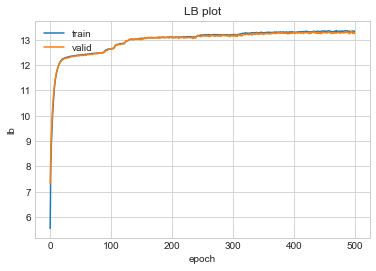

Overall training lb: 13.334550
Overall validation lb: 13.256688


In [12]:
plt.plot(total_lb)
plt.plot(total_vlb)
plt.title('LB plot')
plt.ylabel('lb')
plt.xlabel('epoch')
plt.legend(['train','valid'], loc='upper left')
plt.show()
print('Overall training lb: {:.6f}'.format(total_lb[-1]))
print('Overall validation lb: {:.6f}'.format(total_vlb[-1]))

![](https://tbrain.trendmicro.com.tw/Content/img/18etf.png)

#### Todo:
1. Check missing data / value
2. Do more EDA on dataset
3. Try more baseline models (LSTM, GRU, CNN-1D, XGBoost, SVM, ...) 
4. Add Candlestick chart
5. Add n-fold cross validation
